In [11]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, levene, spearmanr, mannwhitneyu, kruskal
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Load the dataset
file_path = 'AirQuality.csv'
data = pd.read_csv(file_path)

# Print the data
print(tabulate(data, headers='keys', tablefmt='psql'))

+-----+------------------------+--------+-----------+-----------+---------------+------------+---------------+
|     | Country                |   Year |     PM2.5 |      PM10 |   TotalDeaths |   PMDeaths |   CitiesCount |
|-----+------------------------+--------+-----------+-----------+---------------+------------+---------------|
|   0 | Albania                |   2015 |  21.79    |  32.415   |      42.2998  |   21.7861  |             2 |
|   1 | Albania                |   2016 |  21.48    |  32.385   |      41.0188  |   20.8107  |             2 |
|   2 | Argentina              |   2015 |  10.26    |  27.87    |      33.0869  |   29.1591  |             1 |
|   3 | Australia              |   2010 |   8.04    |  15.3233  |      13.5717  |   13.1404  |             3 |
|   4 | Australia              |   2011 |   7.31667 |  14.4433  |      13.7276  |   13.2767  |             3 |
|   5 | Australia              |   2012 |   8.64    |  17.392   |      12.6597  |   12.1964  |             5 |
|

In [12]:
# Fungsi untuk mendeteksi outlier menggunakan metode IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Fungsi untuk menghitung batas atas dan batas bawah menggunakan metode IQR
def calculate_iqr_bounds(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [13]:
# Mendeteksi outlier pada kolom yang relevan menggunakan metode IQR
outliers_pm25_iqr = detect_outliers_iqr(data, 'PM2.5')
outliers_pm10_iqr = detect_outliers_iqr(data, 'PM10')
outliers_totaldeaths_iqr = detect_outliers_iqr(data, 'TotalDeaths')
outliers_pmdeaths_iqr = detect_outliers_iqr(data, 'PMDeaths')

In [14]:
# Menampilkan jumlah outlier yang terdeteksi dengan kedua metode
outlier_counts = {
    'PM2.5': {'IQR': len(outliers_pm25_iqr)},
    'PM10': {'IQR': len(outliers_pm10_iqr)},
    'TotalDeaths': {'IQR': len(outliers_totaldeaths_iqr)},
    'PMDeaths': {'IQR': len(outliers_pmdeaths_iqr)}
}

print(outlier_counts)

{'PM2.5': {'IQR': 33}, 'PM10': {'IQR': 38}, 'TotalDeaths': {'IQR': 30}, 'PMDeaths': {'IQR': 12}}


In [15]:
# Menghitung batas atas dan batas bawah menggunakan metode IQR untuk masing-masing kolom
bounds_pm25 = calculate_iqr_bounds(data, 'PM2.5')
bounds_pm10 = calculate_iqr_bounds(data, 'PM10')
bounds_totaldeaths = calculate_iqr_bounds(data, 'TotalDeaths')
bounds_pmdeaths = calculate_iqr_bounds(data, 'PMDeaths')

bounds = {
    'PM2.5': bounds_pm25,
    'PM10': bounds_pm10,
    'TotalDeaths': bounds_totaldeaths,
    'PMDeaths': bounds_pmdeaths
}

print(bounds)

{'PM2.5': (np.float64(-9.358333333333336), np.float64(45.615)), 'PM10': (np.float64(-29.133333333333333), np.float64(99.56)), 'TotalDeaths': (np.float64(-24.876760047315877), np.float64(89.76698209895227)), 'PMDeaths': (np.float64(-10.174518445707218), np.float64(59.713174248411164))}


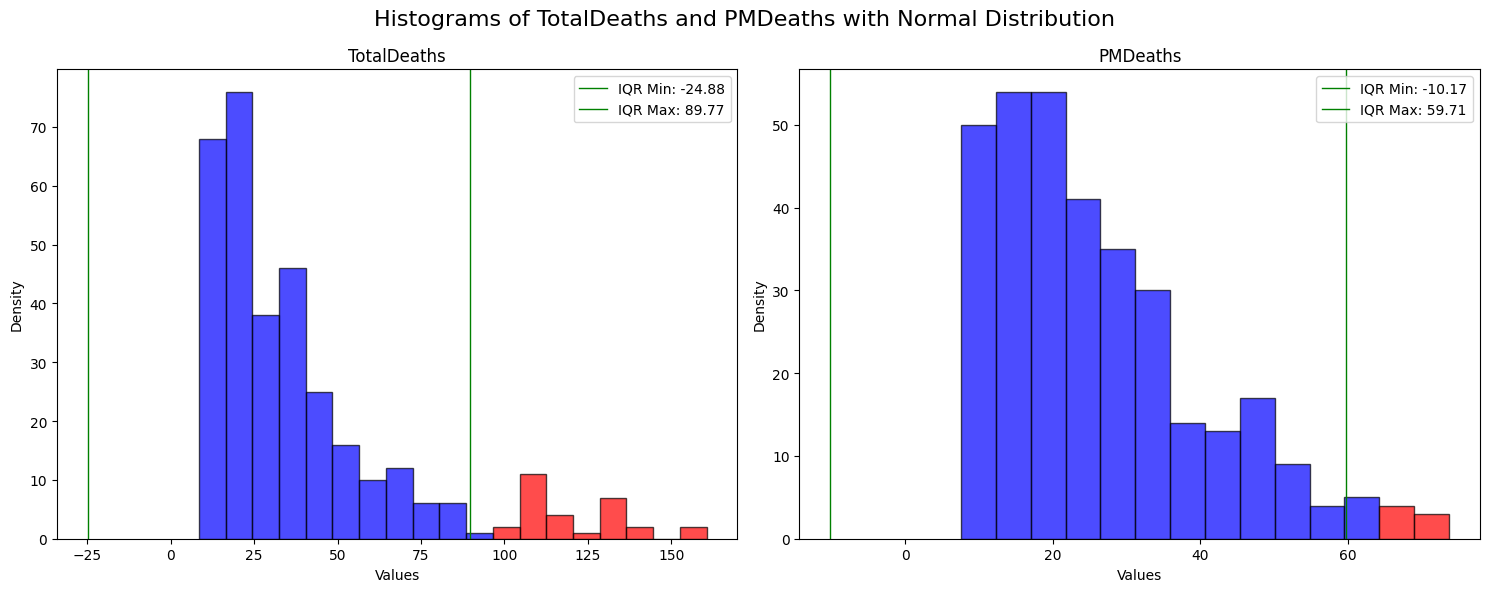

Shapiro-Wilk Test for TotalDeaths:
  Statistic: 0.796969
  p-value: 0.00000000000000000004

Shapiro-Wilk Test for PMDeaths:
  Statistic: 0.910734
  p-value: 0.00000000000038312929



In [16]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for TotalDeaths
lower_bound_totaldeaths, upper_bound_totaldeaths = bounds['TotalDeaths']
bins_totaldeaths = np.histogram_bin_edges(data['TotalDeaths'], bins='auto')
hist_totaldeaths, edges_totaldeaths = np.histogram(data['TotalDeaths'], bins=bins_totaldeaths)

# Manually plot each bin
for count, edge in zip(hist_totaldeaths, edges_totaldeaths[:-1]):
    color = 'red' if edge < lower_bound_totaldeaths or edge > upper_bound_totaldeaths else 'blue'
    ax1.bar(edge, count, width=(edges_totaldeaths[1] - edges_totaldeaths[0]), color=color, align='edge', edgecolor='black', alpha=0.7)

ax1.axvline(lower_bound_totaldeaths, color='green', linestyle='-', linewidth=1, label=f'IQR Min: {lower_bound_totaldeaths:.2f}')
ax1.axvline(upper_bound_totaldeaths, color='green', linestyle='-', linewidth=1, label=f'IQR Max: {upper_bound_totaldeaths:.2f}')

ax1.set_title('TotalDeaths')
ax1.set_xlabel('Values')
ax1.set_ylabel('Density')
ax1.legend()

# Plot for PMDeaths
lower_bound_pmdeaths, upper_bound_pmdeaths = bounds['PMDeaths']
bins_pmdeaths = np.histogram_bin_edges(data['PMDeaths'], bins='auto')
hist_pmdeaths, edges_pmdeaths = np.histogram(data['PMDeaths'], bins=bins_pmdeaths)

# Manually plot each bin
for count, edge in zip(hist_pmdeaths, edges_pmdeaths[:-1]):
    color = 'red' if edge < lower_bound_pmdeaths or edge > upper_bound_pmdeaths else 'blue'
    ax2.bar(edge, count, width=(edges_pmdeaths[1] - edges_pmdeaths[0]), color=color, align='edge', edgecolor='black', alpha=0.7)

ax2.axvline(lower_bound_pmdeaths, color='green', linestyle='-', linewidth=1, label=f'IQR Min: {lower_bound_pmdeaths:.2f}')
ax2.axvline(upper_bound_pmdeaths, color='green', linestyle='-', linewidth=1, label=f'IQR Max: {upper_bound_pmdeaths:.2f}')

ax2.set_title('PMDeaths')
ax2.set_xlabel('Values')
ax2.set_ylabel('Density')
ax2.legend()

plt.suptitle('Histograms of TotalDeaths and PMDeaths with Normal Distribution', fontsize=16)
plt.tight_layout()
plt.show()

# Uji Normalitas
shapiro_total_deaths = shapiro(data['TotalDeaths'])
shapiro_pm_deaths = shapiro(data['PMDeaths'])

# Menampilkan hasil uji asumsi
print("Shapiro-Wilk Test for TotalDeaths:")
print(f"  Statistic: {shapiro_total_deaths.statistic:.6f}")
print(f"  p-value: {shapiro_total_deaths.pvalue:.20f}\n")

print("Shapiro-Wilk Test for PMDeaths:")
print(f"  Statistic: {shapiro_pm_deaths.statistic:.6f}")
print(f"  p-value: {shapiro_pm_deaths.pvalue:.20f}\n")

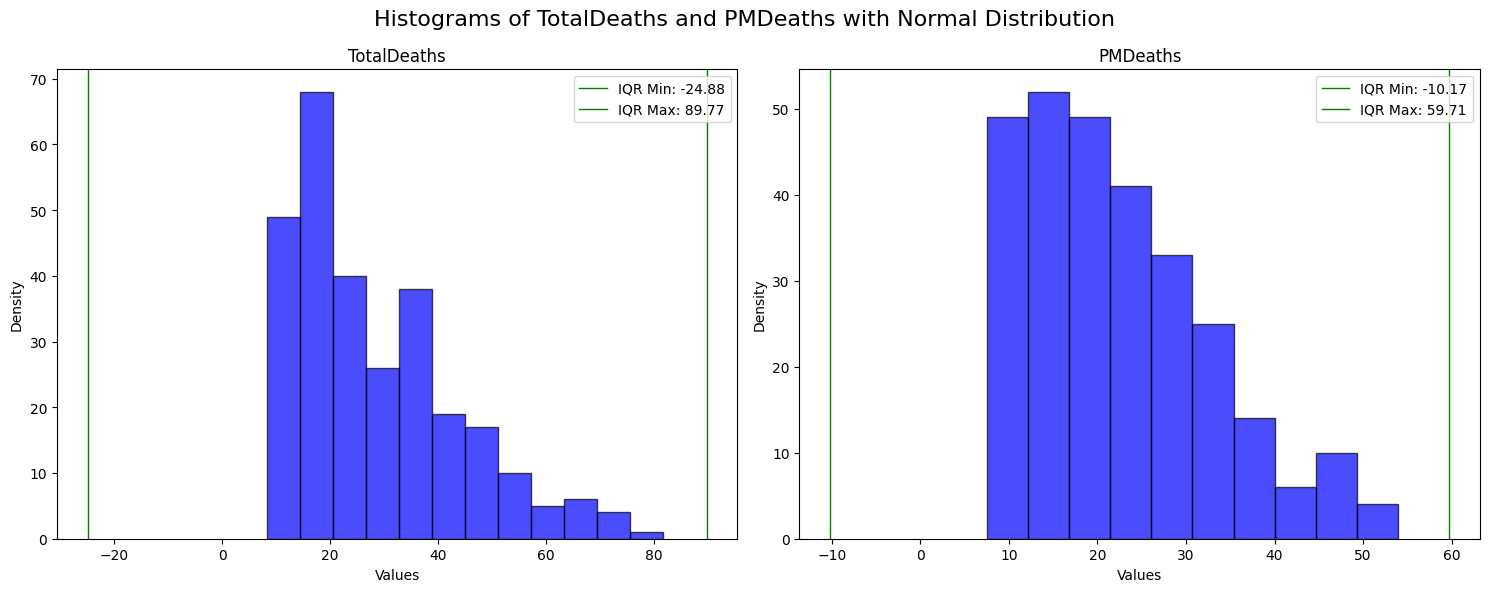

Shapiro-Wilk Test for TotalDeaths:
  Statistic: 0.917984
  p-value: 0.00000000002429298236

Shapiro-Wilk Test for PMDeaths:
  Statistic: 0.937653
  p-value: 0.00000000148370539916



In [17]:
file_path = 'NoOutlier.csv'
data2 = pd.read_csv(file_path)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for TotalDeaths
bins_totaldeaths = np.histogram_bin_edges(data2['TotalDeaths'], bins='auto')
hist_totaldeaths, edges_totaldeaths = np.histogram(data2['TotalDeaths'], bins=bins_totaldeaths)

# Manually plot each bin
for count, edge in zip(hist_totaldeaths, edges_totaldeaths[:-1]):
    color = 'red' if edge < lower_bound_totaldeaths or edge > upper_bound_totaldeaths else 'blue'
    ax1.bar(edge, count, width=(edges_totaldeaths[1] - edges_totaldeaths[0]), color=color, align='edge', edgecolor='black', alpha=0.7)

ax1.axvline(lower_bound_totaldeaths, color='green', linestyle='-', linewidth=1, label=f'IQR Min: {lower_bound_totaldeaths:.2f}')
ax1.axvline(upper_bound_totaldeaths, color='green', linestyle='-', linewidth=1, label=f'IQR Max: {upper_bound_totaldeaths:.2f}')

ax1.set_title('TotalDeaths')
ax1.set_xlabel('Values')
ax1.set_ylabel('Density')
ax1.legend()

# Plot for PMDeaths
bins_pmdeaths = np.histogram_bin_edges(data2['PMDeaths'], bins='auto')
hist_pmdeaths, edges_pmdeaths = np.histogram(data2['PMDeaths'], bins=bins_pmdeaths)

# Manually plot each bin
for count, edge in zip(hist_pmdeaths, edges_pmdeaths[:-1]):
    color = 'red' if edge < lower_bound_pmdeaths or edge > upper_bound_pmdeaths else 'blue'
    ax2.bar(edge, count, width=(edges_pmdeaths[1] - edges_pmdeaths[0]), color=color, align='edge', edgecolor='black', alpha=0.7)

ax2.axvline(lower_bound_pmdeaths, color='green', linestyle='-', linewidth=1, label=f'IQR Min: {lower_bound_pmdeaths:.2f}')
ax2.axvline(upper_bound_pmdeaths, color='green', linestyle='-', linewidth=1, label=f'IQR Max: {upper_bound_pmdeaths:.2f}')

ax2.set_title('PMDeaths')
ax2.set_xlabel('Values')
ax2.set_ylabel('Density')
ax2.legend()

plt.suptitle('Histograms of TotalDeaths and PMDeaths with Normal Distribution', fontsize=16)
plt.tight_layout()
plt.show()

# Uji Normalitas
shapiro_total_deaths = shapiro(data2['TotalDeaths'])
shapiro_pm_deaths = shapiro(data2['PMDeaths'])

# Menampilkan hasil uji asumsi
print("Shapiro-Wilk Test for TotalDeaths:")
print(f"  Statistic: {shapiro_total_deaths.statistic:.6f}")
print(f"  p-value: {shapiro_total_deaths.pvalue:.20f}\n")

print("Shapiro-Wilk Test for PMDeaths:")
print(f"  Statistic: {shapiro_pm_deaths.statistic:.6f}")
print(f"  p-value: {shapiro_pm_deaths.pvalue:.20f}\n")


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13648\3468597240.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13648\3468597240.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


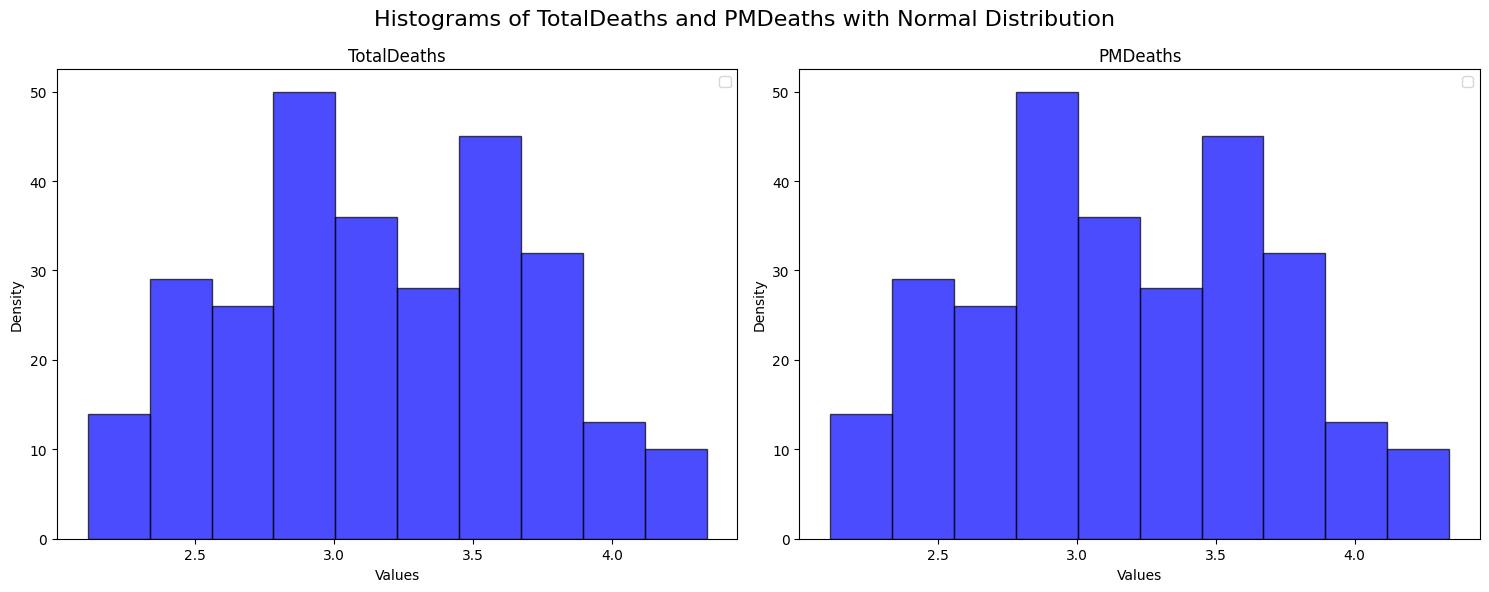

Shapiro-Wilk Test for TotalDeaths:
  Statistic: 0.982377
  p-value: 0.00146116596243016394

Shapiro-Wilk Test for PMDeaths:
  Statistic: 0.982467
  p-value: 0.00151908431194167255



In [18]:
# transformasi boxcox
from scipy.stats import boxcox 
log_total_deaths, _ = boxcox(data2['TotalDeaths'])
log_pm_deaths, _ = boxcox(data2['PMDeaths'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for TotalDeaths
bins_totaldeaths = np.histogram_bin_edges(log_total_deaths, bins='auto')
hist_totaldeaths, edges_totaldeaths = np.histogram(log_total_deaths, bins=bins_totaldeaths)

# Manually plot each bin
for count, edge in zip(hist_totaldeaths, edges_totaldeaths[:-1]):
    color = 'red' if edge < lower_bound_totaldeaths or edge > upper_bound_totaldeaths else 'blue'
    ax1.bar(edge, count, width=(edges_totaldeaths[1] - edges_totaldeaths[0]), color=color, align='edge', edgecolor='black', alpha=0.7)

ax1.set_title('TotalDeaths')
ax1.set_xlabel('Values')
ax1.set_ylabel('Density')
ax1.legend()

# Plot for PMDeaths
bins_pmdeaths = np.histogram_bin_edges(log_total_deaths, bins='auto')
hist_pmdeaths, edges_pmdeaths = np.histogram(log_total_deaths, bins=bins_pmdeaths)

# Manually plot each bin
for count, edge in zip(hist_pmdeaths, edges_pmdeaths[:-1]):
    color = 'red' if edge < lower_bound_pmdeaths or edge > upper_bound_pmdeaths else 'blue'
    ax2.bar(edge, count, width=(edges_pmdeaths[1] - edges_pmdeaths[0]), color=color, align='edge', edgecolor='black', alpha=0.7)

ax2.set_title('PMDeaths')
ax2.set_xlabel('Values')
ax2.set_ylabel('Density')
ax2.legend()

plt.suptitle('Histograms of TotalDeaths and PMDeaths with Normal Distribution', fontsize=16)
plt.tight_layout()
plt.show()

# Uji Normalitas
shapiro_total_deaths = shapiro(log_total_deaths)
shapiro_pm_deaths = shapiro(log_pm_deaths)

# Menampilkan hasil uji asumsi
print("Shapiro-Wilk Test for TotalDeaths:")
print(f"  Statistic: {shapiro_total_deaths.statistic:.6f}")
print(f"  p-value: {shapiro_total_deaths.pvalue:.20f}\n")

print("Shapiro-Wilk Test for PMDeaths:")
print(f"  Statistic: {shapiro_pm_deaths.statistic:.6f}")
print(f"  p-value: {shapiro_pm_deaths.pvalue:.20f}\n")



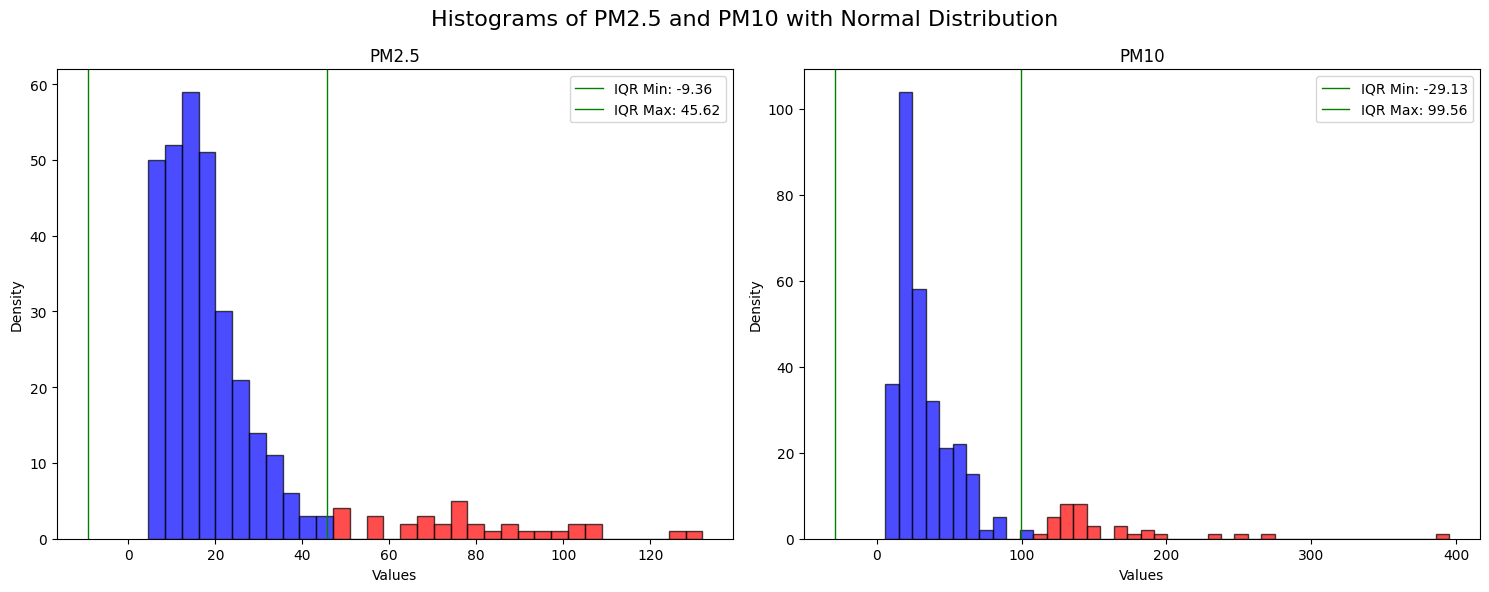

Shapiro-Wilk Test for PM2.5:
  Statistic: 0.690672
  p-value: 0.00000000000000000000

Shapiro-Wilk Test for PM10:
  Statistic: 0.656777
  p-value: 0.00000000000000000000



In [19]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for PM2.5
lower_bound_pm25, upper_bound_pm25 = bounds['PM2.5']
bins_pm25 = np.histogram_bin_edges(data['PM2.5'], bins='auto')
hist_pm25, edges_pm25 = np.histogram(data['PM2.5'], bins=bins_pm25)

# Manually plot each bin
for count, edge in zip(hist_pm25, edges_pm25[:-1]):
    color = 'red' if edge < lower_bound_pm25 or edge > upper_bound_pm25 else 'blue'
    ax1.bar(edge, count, width=(edges_pm25[1] - edges_pm25[0]), color=color, align='edge', edgecolor='black', alpha=0.7)

ax1.axvline(lower_bound_pm25, color='green', linestyle='-', linewidth=1, label=f'IQR Min: {lower_bound_pm25:.2f}')
ax1.axvline(upper_bound_pm25, color='green', linestyle='-', linewidth=1, label=f'IQR Max: {upper_bound_pm25:.2f}')

ax1.set_title('PM2.5')
ax1.set_xlabel('Values')
ax1.set_ylabel('Density')
ax1.legend()

# Plot for PM10
lower_bound_pm10, upper_bound_pm10 = bounds['PM10']
bins_pm10 = np.histogram_bin_edges(data['PM10'], bins='auto')
hist_pm10, edges_pm10 = np.histogram(data['PM10'], bins=bins_pm10)

# Manually plot each bin
for count, edge in zip(hist_pm10, edges_pm10[:-1]):
    color = 'red' if edge < lower_bound_pm10 or edge > upper_bound_pm10 else 'blue'
    ax2.bar(edge, count, width=(edges_pm10[1] - edges_pm10[0]), color=color, align='edge', edgecolor='black', alpha=0.7)

ax2.axvline(lower_bound_pm10, color='green', linestyle='-', linewidth=1, label=f'IQR Min: {lower_bound_pm10:.2f}')
ax2.axvline(upper_bound_pm10, color='green', linestyle='-', linewidth=1, label=f'IQR Max: {upper_bound_pm10:.2f}')

ax2.set_title('PM10')
ax2.set_xlabel('Values')
ax2.set_ylabel('Density')
ax2.legend()

plt.suptitle('Histograms of PM2.5 and PM10 with Normal Distribution', fontsize=16)
plt.tight_layout()
plt.show()

# Uji Normalitas
shapiro_pm25 = shapiro(data['PM2.5'])
shapiro_pm10 = shapiro(data['PM10'])

# Menampilkan hasil uji asumsi
print("Shapiro-Wilk Test for PM2.5:")
print(f"  Statistic: {shapiro_pm25.statistic:.6f}")
print(f"  p-value: {shapiro_pm25.pvalue:.20f}\n")

print("Shapiro-Wilk Test for PM10:")
print(f"  Statistic: {shapiro_pm10.statistic:.6f}")
print(f"  p-value: {shapiro_pm10.pvalue:.20f}\n")

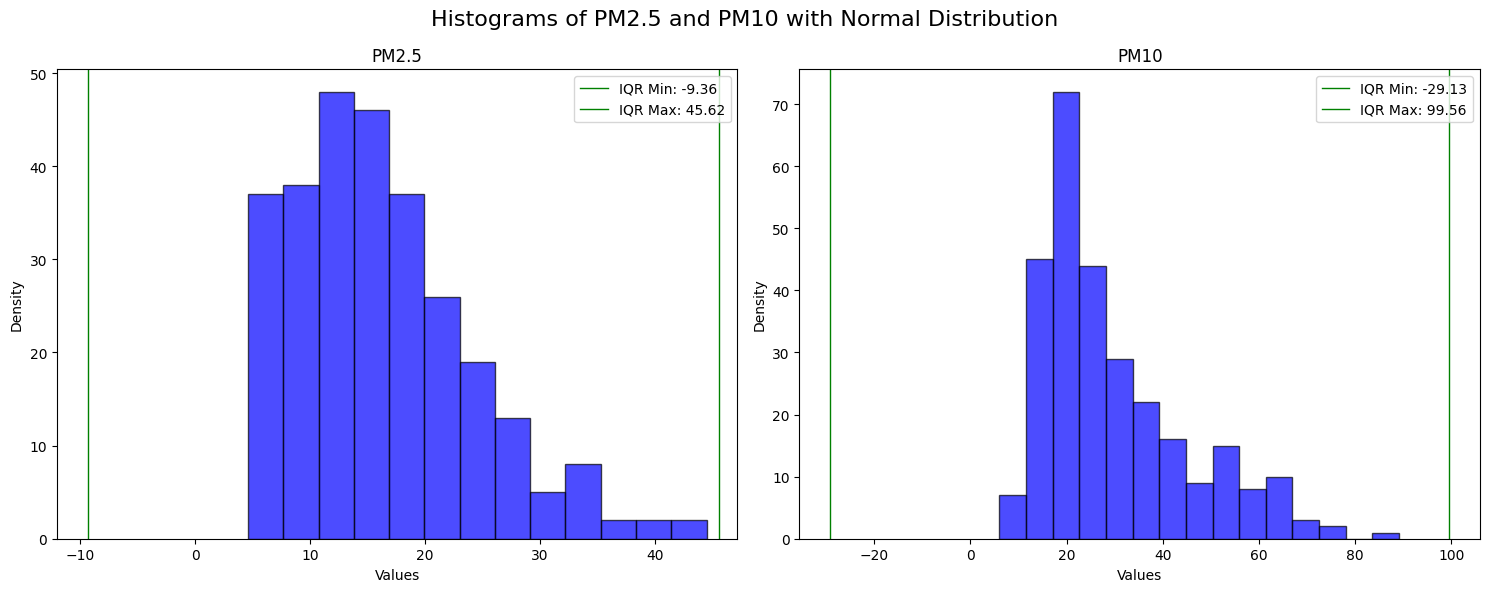

Shapiro-Wilk Test for PM2.5:
  Statistic: 0.938778
  p-value: 0.00000000192199789957

Shapiro-Wilk Test for PM10:
  Statistic: 0.896361
  p-value: 0.00000000000052822118



In [20]:
file_path = 'NoOutlier.csv'
data2 = pd.read_csv(file_path)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for PM2.5
lower_bound_pm25, upper_bound_pm25 = bounds['PM2.5']
bins_pm25 = np.histogram_bin_edges(data2['PM2.5'], bins='auto')
hist_pm25, edges_pm25 = np.histogram(data2['PM2.5'], bins=bins_pm25)

# Manually plot each bin
for count, edge in zip(hist_pm25, edges_pm25[:-1]):
    color = 'red' if edge < lower_bound_pm25 or edge > upper_bound_pm25 else 'blue'
    ax1.bar(edge, count, width=(edges_pm25[1] - edges_pm25[0]), color=color, align='edge', edgecolor='black', alpha=0.7)

ax1.axvline(lower_bound_pm25, color='green', linestyle='-', linewidth=1, label=f'IQR Min: {lower_bound_pm25:.2f}')
ax1.axvline(upper_bound_pm25, color='green', linestyle='-', linewidth=1, label=f'IQR Max: {upper_bound_pm25:.2f}')

ax1.set_title('PM2.5')
ax1.set_xlabel('Values')
ax1.set_ylabel('Density')
ax1.legend()

# Plot for PM10
lower_bound_pm10, upper_bound_pm10 = bounds['PM10']
bins_pm10 = np.histogram_bin_edges(data2['PM10'], bins='auto')
hist_pm10, edges_pm10 = np.histogram(data2['PM10'], bins=bins_pm10)

# Manually plot each bin
for count, edge in zip(hist_pm10, edges_pm10[:-1]):
    color = 'red' if edge < lower_bound_pm10 or edge > upper_bound_pm10 else 'blue'
    ax2.bar(edge, count, width=(edges_pm10[1] - edges_pm10[0]), color=color, align='edge', edgecolor='black', alpha=0.7)

ax2.axvline(lower_bound_pm10, color='green', linestyle='-', linewidth=1, label=f'IQR Min: {lower_bound_pm10:.2f}')
ax2.axvline(upper_bound_pm10, color='green', linestyle='-', linewidth=1, label=f'IQR Max: {upper_bound_pm10:.2f}')

ax2.set_title('PM10')
ax2.set_xlabel('Values')
ax2.set_ylabel('Density')
ax2.legend()

plt.suptitle('Histograms of PM2.5 and PM10 with Normal Distribution', fontsize=16)
plt.tight_layout()
plt.show()

# Uji Normalitas
shapiro_pm25 = shapiro(data2['PM2.5'])
shapiro_pm10 = shapiro(data2['PM10'])

# Menampilkan hasil uji asumsi
print("Shapiro-Wilk Test for PM2.5:")
print(f"  Statistic: {shapiro_pm25.statistic:.6f}")
print(f"  p-value: {shapiro_pm25.pvalue:.20f}\n")

print("Shapiro-Wilk Test for PM10:")
print(f"  Statistic: {shapiro_pm10.statistic:.6f}")
print(f"  p-value: {shapiro_pm10.pvalue:.20f}\n") 

In [21]:
import pandas as pd

# Fungsi untuk menghitung batas atas dan bawah menggunakan metode IQR
def calculate_iqr_bounds(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Membaca dataset
file_path = 'AirQuality.csv'  # ganti dengan path ke dataset Anda
data2 = pd.read_csv(file_path)

# Menghitung batas atas dan bawah untuk setiap kolom
bounds_pm25 = calculate_iqr_bounds(data, 'PM2.5')
bounds_pm10 = calculate_iqr_bounds(data, 'PM10')
bounds_totaldeaths = calculate_iqr_bounds(data, 'TotalDeaths')
bounds_pmdeaths = calculate_iqr_bounds(data, 'PMDeaths')

# Membuat filter untuk masing-masing kolom
filter_pm25 = (data['PM2.5'] >= bounds_pm25[0]) & (data['PM2.5'] <= bounds_pm25[1])
filter_pm10 = (data['PM10'] >= bounds_pm10[0]) & (data['PM10'] <= bounds_pm10[1])
filter_totaldeaths = (data['TotalDeaths'] >= bounds_totaldeaths[0]) & (data['TotalDeaths'] <= bounds_totaldeaths[1])
filter_pmdeaths = (data['PMDeaths'] >= bounds_pmdeaths[0]) & (data['PMDeaths'] <= bounds_pmdeaths[1])

# Menggabungkan semua filter
combined_filter = filter_pm25 & filter_pm10 & filter_totaldeaths & filter_pmdeaths

# Membuat dataset baru tanpa outlier
cleaned_data = data[combined_filter]

# Menyimpan dataset baru ke file CSV
cleaned_data.to_csv('cleaned_dataset_no_outliers.csv', index=False)

In [30]:
import pandas as pd
file_path = 'NoOutlier.csv'
data3 = pd.read_csv(file_path)

filter_2015 = (data3['Year'] == 2015)
filter_2017 = (data3['Year'] == 2017)

data2015 = data3[filter_2015]
data2017 = data3[filter_2017]

combined = pd.concat([data2015, data2017])
combined.to_csv('data_2015_2017.csv', index=False)

In [23]:
file_path = 'data_2015.csv'
data4 = pd.read_csv(file_path)

# Uji Normalitas
shapiro_pm25 = shapiro(data4['PM2.5'])
shapiro_pm10 = shapiro(data4['PM10'])

# Menampilkan hasil uji asumsi
print("Shapiro-Wilk Test for PM2.5:")
print(f"  Statistic: {shapiro_pm25.statistic:.6f}")
print(f"  p-value: {shapiro_pm25.pvalue:.20f}\n")

print("Shapiro-Wilk Test for PM10:")
print(f"  Statistic: {shapiro_pm10.statistic:.6f}")
print(f"  p-value: {shapiro_pm10.pvalue:.20f}\n") 



Shapiro-Wilk Test for PM2.5:
  Statistic: 0.929090
  p-value: 0.00782054370025865413

Shapiro-Wilk Test for PM10:
  Statistic: 0.912669
  p-value: 0.00212349208149857768

